In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter


In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
from src.user_encoding_lib import UserEncoder


In [35]:
config_dir = 'runs/baseline_Jul29_17-43-20'
config_file = 'config.json'

# Load config file
with open(os.path.join(config_dir, config_file), 'r') as f:
    config = json.load(f)

In [36]:
trainset, valset, conditioner, user_ids, condition_set, X_test, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Number of (subsampled/filtered) users....6830
Number of (subsampled) days...............365
Number of (aggregated) features............24
Mean of enrolments: 28.59
Number of Training Points: 2065749
Number of Validation Points: 229527


In [38]:
num_missing_days = [x.shape[0] for x in X_test["list"]]
num_users =len(num_missing_days)

In [39]:
enrolment_matrix = np.zeros((num_users, 365))
for i in range(num_users):
    enrolment_matrix[i, num_missing_days[i]:] = 1

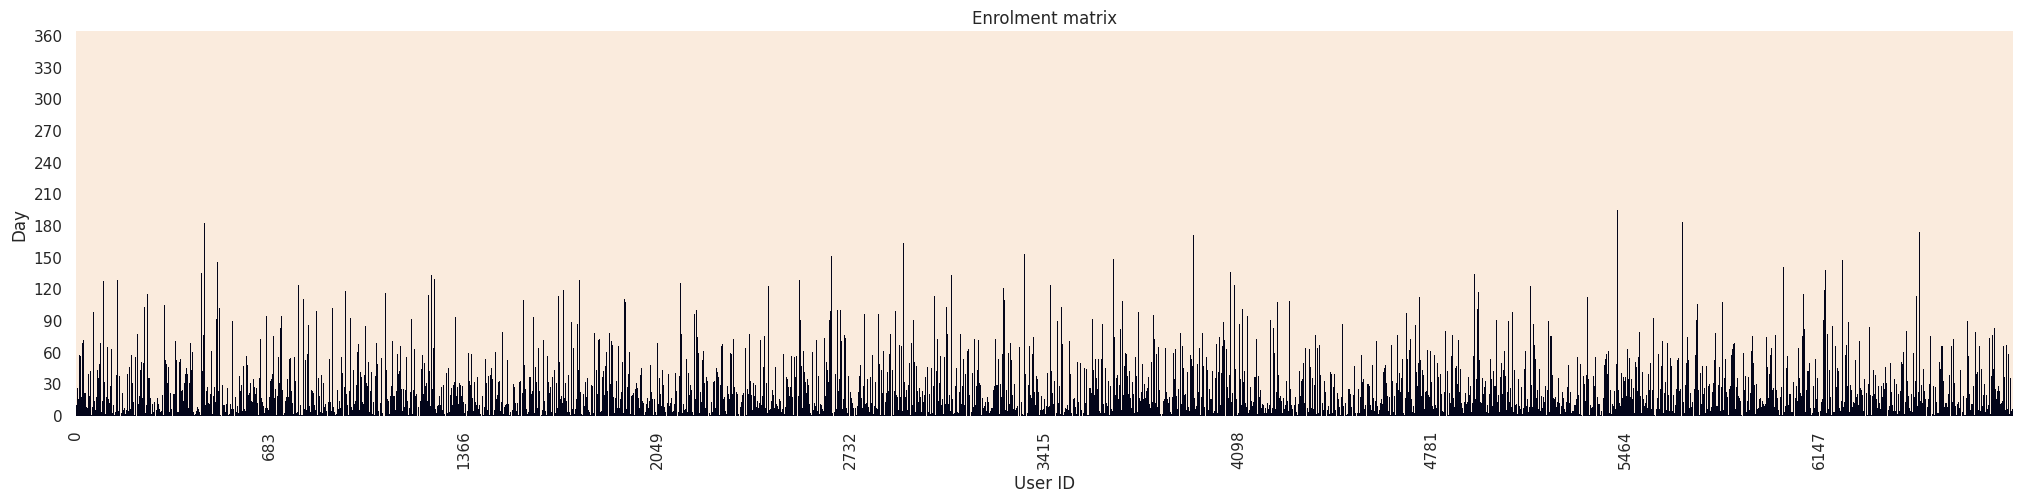

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.heatmap(enrolment_matrix.T, ax=ax, cbar=False)
ax.set_title("Enrolment matrix")
ax.set_xlabel("User ID")
ax.set_ylabel("Day")
## flip the y axis
plt.gca().invert_yaxis()
plt.yticks(np.arange(0, 365, 30), np.arange(0, 365, 30))
plt.xticks(np.arange(0, num_users, num_users//10), np.arange(0, num_users, num_users//10))
plt.show()

In [41]:
# Load model
num_features = valset.inputs.shape[1]
model = CVAE(input_dim=num_features, conditioner=conditioner, **config["model"])
model.load(config_dir)

USING SIGMA_LIM!
USING MARGINAL_STD_LIM!
USING SIGMA_LIM!
USING MARGINAL_STD_LIM!


In [49]:
config["data"]

{'random_seed': 2112,
 'dataset_dir': 'data',
 'dataset_name': 'goi4_dp_full_Gipuzkoa',
 'val_ratio': 0.1,
 'resolution': 1,
 'pad': 0,
 'ampute_params': {'a': 0.85, 'b': 10.0},
 'subsample_rate': {'user': 1, 'day': 1},
 'scaling': {'shift': 1, 'zero_id': -3, 'log_space': True},
 'condition_tag_list': ['months', 'weekdays'],
 'user_embedding_kwargs': {'model_kwargs': {'num_topics': 20,
   'num_clusters': 1000,
   'reduce_dim': False,
   'num_lower_dims': None},
  'fit_kwargs': {'lda': {'perp_tol': 0.05,
    'max_iter': 10,
    'batch_size': 64,
    'verbose': True,
    'learning_method': 'online',
    'evaluate_every': 10,
    'n_jobs': -1,
    'doc_topic_prior': 0.05,
    'topic_word_prior': 0.001}}}}

In [52]:
x_test = utils.zero_preserved_log_normalize(X_test["flat"]*1.0, nonzero_mean, nonzero_std, log_output=config["data"]["scaling"]["log_space"])
x_test = torch.tensor(x_test).float()

In [43]:
conditions = condition_set["test"].copy()

In [44]:
x_rec, z_rec = model.reconstruct(x_test, torch.tensor(conditioner.transform(conditions)).float())

In [45]:
rll_val = model.reconstruction_loglikelihood(x_test, x_rec["params"]).detach().numpy()
kl_val = model.kl_divergence(z_rec["params"], prior_params=model.prior_params).detach().numpy()
elbo_val = rll_val - kl_val

In [46]:
elbo_val.mean()

-8.1308155

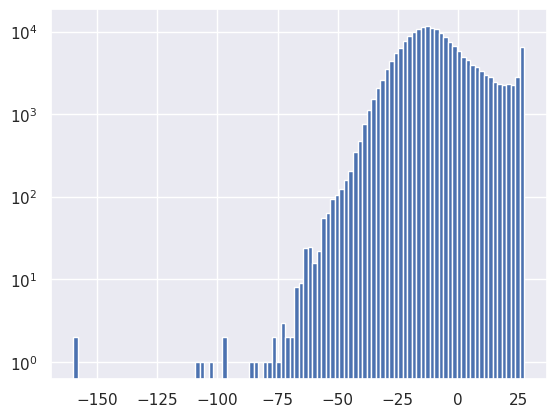

In [47]:
plt.hist(elbo_val, bins=100, log=True)
plt.show()